In [1]:
# Install libraries
!pip install sentence-transformers
!pip install datasets
!pip install scikit-learn


In [2]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
! pip install --upgrade datasets

In [4]:
# 1. Load PAWS Dataset from Huggingface
paws = load_dataset("paws", "labeled_final", split="train")

# 2. Sample a smaller subset (optional, for faster training)
small_texts1 = list(paws['sentence1'])[:10000]
small_labels = list(paws['label'])[:10000]

# 3. Train/Validation Split (Stratified)
train_texts1, val_texts1, train_labels, val_labels = train_test_split(
    small_texts1, small_labels, test_size=0.2, random_state=42, stratify=small_labels
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.79k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/8.43M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.24M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/49401 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [6]:
# Reproducibility
import random
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [7]:
# 4. Create custom Dataset class
class PawsDataset(Dataset):
    def __init__(self, texts1, labels):
        self.texts1 = texts1
        self.labels = labels
        self.embedder = SentenceTransformer('all-MiniLM-L6-v2')

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sent1 = self.texts1[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        emb1 = self.embedder.encode(sent1, convert_to_tensor=True)
        return emb1, label

In [8]:
# 5. Create Datasets and Dataloaders
train_dataset = PawsDataset(train_texts1, train_labels)
val_dataset = PawsDataset(val_texts1, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
# 6. Define simple SBERT Classifier
class SBERTClassifier(nn.Module):
    def __init__(self, input_dim=384, hidden_dim=512, num_classes=2):
        super(SBERTClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

In [10]:
# 7. Define training and evaluation functions
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for embeddings, labels in tqdm(dataloader):
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        embeddings = embeddings.view(embeddings.size(0), -1)
        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    preds, truths = [], []

    with torch.no_grad():
        for embeddings, labels in dataloader:
            embeddings = embeddings.to(device)
            labels = labels.to(device)
            embeddings = embeddings.view(embeddings.size(0), -1)
            outputs = model(embeddings)
            pred = torch.argmax(outputs, dim=1)
            preds.extend(pred.cpu().numpy())
            truths.extend(labels.cpu().numpy())

    acc = accuracy_score(truths, preds)
    f1 = f1_score(truths, preds)
    return acc, f1, truths, preds


In [11]:
# 8. Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SBERTClassifier(input_dim=384).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

In [12]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [13]:
# 9. Evaluate and Show Confusion Matrix
acc, f1, true_labels, pred_labels = evaluate(model, val_loader, device)
print(f"\nValidation Accuracy: {acc:.4f}")
print(f"Validation F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(true_labels, pred_labels, digits=4))


Validation Accuracy: 0.4860
Validation F1 Score: 0.5459

Classification Report:
               precision    recall  f1-score   support

           0     0.5584    0.3212    0.4078      1102
           1     0.4524    0.6882    0.5459       898

    accuracy                         0.4860      2000
   macro avg     0.5054    0.5047    0.4769      2000
weighted avg     0.5108    0.4860    0.4698      2000



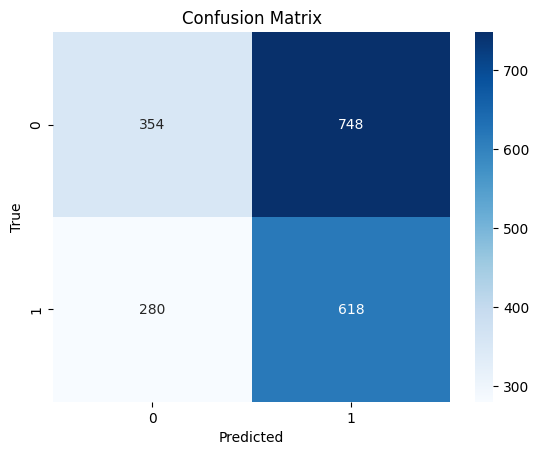

In [14]:
# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
labels = ['0', '1']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()